# Look at kitti data and see if I can convert to azimuth, height, distance format

## Look at kitti in point cloud binary format

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import json
import os

In [24]:
# Load point cloud data
bin_path = '../data/2011_09_26_drive_0017_sync/velodyne_points/data/0000000100.bin'
points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)

In [25]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.'''
    
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the 'box size'.
    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

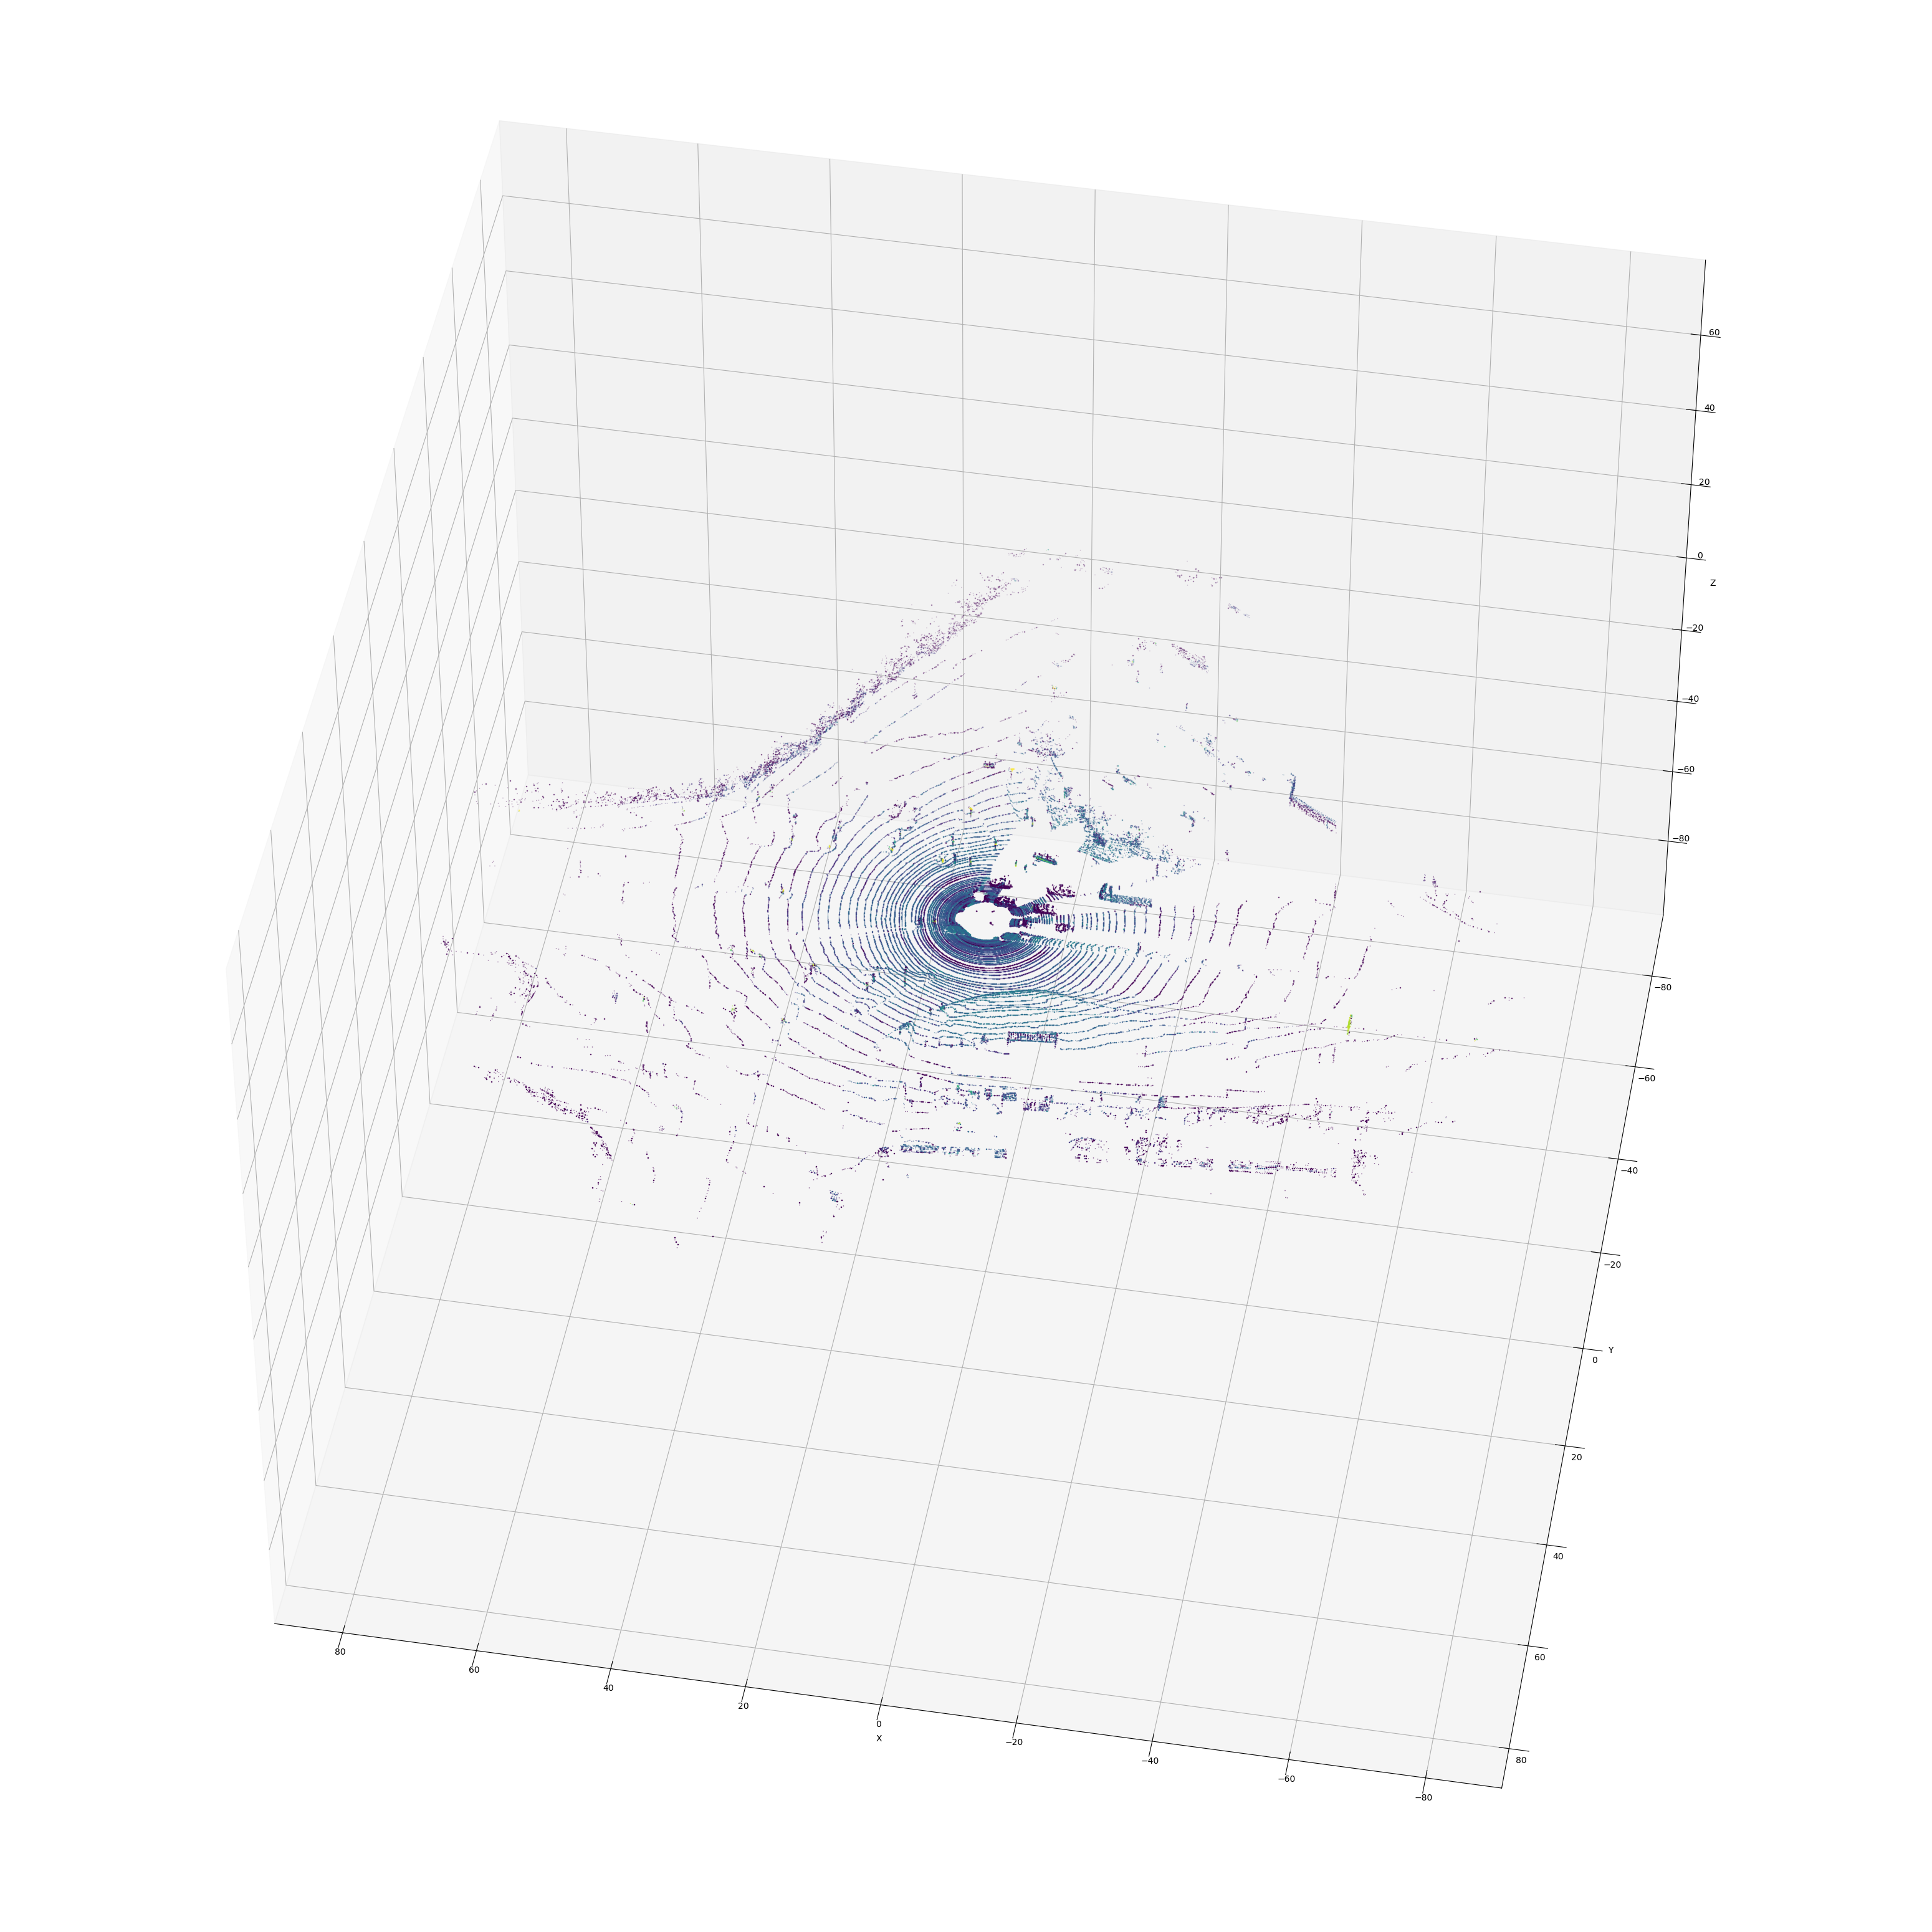

In [26]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0.1, c=points[:, 3], cmap='viridis', marker=',')

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=45, azim=100) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()

## Convert to azimuth, height, distance format, look at that

In [27]:
def convert_points_to_polar(bin_file_path):
    # Load point cloud data from .bin file
    num_points = 4  # x, y, z, intensity
    data = np.fromfile(bin_file_path, dtype=np.float32)
    points = data.reshape(-1, num_points)

    # Calculate azimuth in degrees
    azimuth = np.degrees(np.arctan2(points[:, 1], points[:, 0]))

    # Calculate elevation in degrees
    elevation = np.degrees(np.arctan2(points[:, 2], np.sqrt(points[:, 0]**2 + points[:, 1]**2)))

    # Calculate distance
    distance = np.sqrt(np.sum(points[:, :3]**2, axis=1))

    # Create a DataFrame
    df = pd.DataFrame({
        'Azimuth': azimuth,
        'Elevation': elevation,
        'Distance': distance,
        'Intensity': points[:, 3]
    })

    return df

## What is the distance measured in?

In [28]:
# Usage
polar_df = convert_points_to_polar(bin_path)
print(polar_df.head())

    Azimuth  Elevation   Distance  Intensity
0  0.098019   2.302210  32.760494       0.23
1  0.277548   2.301179  32.849876       0.00
2  0.458117   2.305173  32.544376       0.00
3  0.929024   2.136147  60.175720       0.00
4  1.109021   2.135864  60.130028       0.00


In [29]:
polar_df.describe()

,Azimuth,Elevation,Distance,Intensity
count,116644.000000,116644.000000,116644.000000,116644.000000
mean,4.337594,-9.234881,17.614801,0.215773
std,99.593727,7.052813,16.037220,0.143751
min,-180.000000,-24.227907,1.462862,0.000000
25%,-79.840439,-15.118146,6.063750,0.110000
50%,7.506324,-8.366051,10.986212,0.250000
75%,90.657705,-3.437263,23.127408,0.310000
max,180.000000,3.550540,80.004280,0.990000


In [30]:
# Next steps
# Superimpose all frames into one frame
# Take farthest points

# Divide the vectors into a sort of grid.
# any point can be mapped to it's grid location by "rounding down" to the nearest indicating coordinates

# So make a background map out of all of these points.
# I make a dataframe with each bottom left corner of the grid.
# The I go through each binary file, and for each point, I map it to the grid (by rounding down)
# Each grid square will have a list of distances. I can get the median of the distance for each grid, and the max
# I'll take the median map and the max map and change them back into x,y,z coordinates (maybe take the average of the intensities?)
# And display the map to see what it looks like

# For each point that I'm checking against the background map, I can "round up" to the "top corner" of the square cone.

# Try to make a background map

## Create a "grid" for points
And a dataframe for that grid

In [ ]:
# Start with a super crude grid. I'll just divide the azimuth by every half of a degree, so -180.00, -179.50, -179.00, ..., 179.00, 179.50, 180.00
# That will give me 720 azimuth buckets
# Then I'll have the heights have a minimum of -30, and a maximum of 30, and divide each into 10?
# So I'll start at -30.00, -29.90, -29.80, ..., 29.80, 29.90, 30.00
# So I would like to start with a dataframe that has a row for each grid, so the columns should be
# Azimuth, height, list of distances, list of intensities

In [32]:
# Define your DataFrame as before
def create_initial_dataframe():
    azimuth_range = np.arange(-180, 180.5, 0.5)  # 0.5 degree step; include 180
    height_range = np.arange(-30, 30.1, 0.1)     # 0.1 degree step; include 30

    azimuth, height = np.meshgrid(azimuth_range, height_range)
    azimuth = azimuth.flatten()
    height = height.flatten()

    df = pd.DataFrame({
        'Azimuth': azimuth,
        'Height': height,
        'Distances': [[] for _ in range(len(azimuth))],
        'Intensities': [[] for _ in range(len(azimuth))]
    })
    return df

In [34]:
# # Define the azimuth and height ranges
# azimuth_range = np.arange(-180, 180.5, 0.5)  # 0.5 degree step; include 180
# height_range = np.arange(-30, 30.1, 0.1)     # 0.1 degree step; include 30

# # Create a grid of azimuth and height
# azimuth, height = np.meshgrid(azimuth_range, height_range)
# azimuth = azimuth.flatten()
# height = height.flatten()

# # Create the DataFrame
# df = pd.DataFrame({
#     'Azimuth': azimuth,
#     'Height': height,
#     'Distances': [[] for _ in range(len(azimuth))],
#     'Intensities': [[] for _ in range(len(azimuth))]
# })
df = create_initial_dataframe()

print(df.head())

   Azimuth  Height Distances Intensities
0   -180.0   -30.0        []          []
1   -179.5   -30.0        []          []
2   -179.0   -30.0        []          []
3   -178.5   -30.0        []          []
4   -178.0   -30.0        []          []


## Populate the grid
By going through each frame and mapping each point to the grid

In [36]:
# Function to process each point and assign it to the correct grid row
def process_point(point, df):
    x, y, z, intensity = point
    azimuth = np.degrees(np.arctan2(y, x))
    height = np.degrees(np.arctan2(z, np.sqrt(x**2 + y**2)))
    distance = np.sqrt(x**2 + y**2 + z**2)
    
    # Round down to the nearest grid
    azimuth_index = np.floor((azimuth + 180) / 0.5) * 0.5 - 180
    height_index = np.floor((height + 30) / 0.1) * 0.1 - 30
    
    # Find the corresponding row in DataFrame
    mask = (df['Azimuth'] == azimuth_index) & (df['Height'] == height_index)
    row_index = df[mask].index
    
    # Append the distance and intensity
    if not row_index.empty:
        df.at[row_index[0], 'Distances'].append(distance)
        df.at[row_index[0], 'Intensities'].append(intensity)

In [40]:
# Main function to process all files in a directory
def process_all_files(directory_path, df):
    print('processing files')
    for filename in os.listdir(directory_path):
        print('processing next file')
        if filename.endswith('.bin'):
            print(filename)
            file_path = os.path.join(directory_path, filename)
            data = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
            # Probably convert the whole file here instead of doing it point by point lol
            for point in data:
                process_point(point, df)

In [41]:
directory_path = '../data/2011_09_26_drive_0017_sync/velodyne_points/data'
df = create_initial_dataframe()
print('created dataframe')
process_all_files(directory_path, df)

# Optional: To check some of the data
print(df.loc[df['Distances'].apply(len) > 0])  # Print rows where distances are not empty

created dataframe
processing files
processing next file
0000000071.bin


KeyboardInterrupt: 

## Use the grid point lists to make background maps

## Display background maps